In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.gp_inference import performGP
from src.plot_helper import plot_emission, plot_saver
from src.load_data import get_sample_emission, load_magnetic_coords, load_sample_attributes, load_saved_bolometer_data
from forward_model import get_forward_measurement
from src.constants import PARAMS_STATIC_CART, PARAMS_STATIC_COMB
from src.static_coords import r_coord, z_coord, r_coord_full, z_coord_full
from src.optimize import optimize_for_residuum, optimize_for_combination, optimize_params


In [4]:
mask = np.loadtxt("data/mask.txt").astype(bool)
from src.metrics import residuum, residuum_mean, signal_to_noise, signal_to_noise_mean

  1.011341371005983
  0.9713479729980463
0.12751721876545102


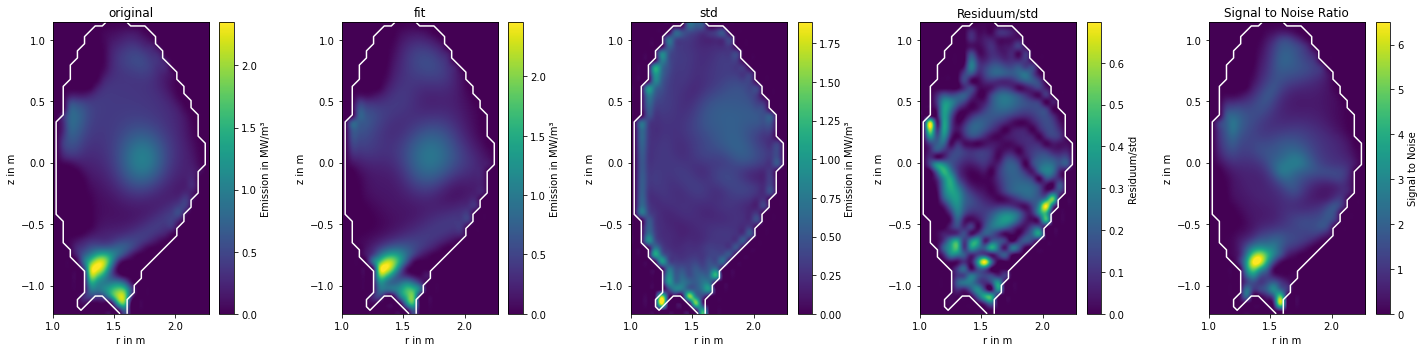

In [4]:
sample = 208

sample_emission = get_sample_emission(sample)
real_measurement = load_saved_bolometer_data(sample)
forward_measurement = get_forward_measurement(sample_emission)
mag_coords = load_magnetic_coords(sample)

#params_comb = [157000, 0.164, 0.27, 33230, 0.212, 7.82]
params_comb = [1.50813082e+06, 8.99373469e-02, 1.62176369e-01, 0*1.78524511e+05, 1.67429066e-01, 8.81967171]
#params_comb = [300000, 0.1, 0.20, 150000, 0.15, 6]
params_cart = [2000000, 0.05, 0.15]


fit_real, cov_post_real = performGP(real_measurement, params_comb,
                            kernel_function="combined_var_z", 
                            magnetic_coords = mag_coords, x_point_up=False)

fit_forward, cov_post_forward = performGP(forward_measurement, params_cart,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords, x_point_up=False)



std_real = np.sqrt(cov_post_real)
std_forward = np.sqrt(cov_post_forward)

residuum_test = residuum(sample_emission, fit_forward, cov_post_forward)
print(residuum_test[mask].mean())
signal_to_noise_test = signal_to_noise(fit_forward, cov_post_forward)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,5))
plot_emission(sample_emission, fig, ax1, title="original")
plot_emission(fit_forward, fig, ax2, title="fit")
plot_emission(std_forward, fig, ax3, title="std")
plot_emission(residuum_test, fig, ax4, convert_to_megawatt=False, custom_scale_label="Residuum/std", title="Residuum/std")
plot_emission(signal_to_noise_test, fig, ax5, convert_to_megawatt=False, custom_scale_label="Signal to Noise", title="Signal to Noise Ratio")
plt.tight_layout()

In [15]:
params_opt = optimize_params(forward_measurement, [500000, 0.08, 0.15, 50000, 0.1, 6],magnetic_coords=mag_coords, kernel_function="combined_var_z", x_point_up=False)

Function call 0: 1422.796
Function call 200: 1416.334
Function call 400: 1416.042
Function call 600: 1416.041
Optimization terminated successfully.
         Current function value: 1416.041492
         Iterations: 390
         Function evaluations: 639
 final_simplex: (array([[7.12267552e+05, 6.71362137e-02, 2.53764215e-01, 1.54195992e+05,
        1.68744617e-01, 2.64470622e+00],
       [7.12267281e+05, 6.71361634e-02, 2.53764305e-01, 1.54196178e+05,
        1.68744634e-01, 2.64471083e+00],
       [7.12267460e+05, 6.71362047e-02, 2.53764209e-01, 1.54196944e+05,
        1.68745331e-01, 2.64471433e+00],
       [7.12267042e+05, 6.71362248e-02, 2.53764179e-01, 1.54196243e+05,
        1.68744695e-01, 2.64471192e+00],
       [7.12267652e+05, 6.71362561e-02, 2.53764264e-01, 1.54195731e+05,
        1.68744398e-01, 2.64471264e+00],
       [7.12267968e+05, 6.71362939e-02, 2.53764318e-01, 1.54195137e+05,
        1.68743530e-01, 2.64470048e+00],
       [7.12267755e+05, 6.71362431e-02, 2.53764437e-

0.8756223219250289


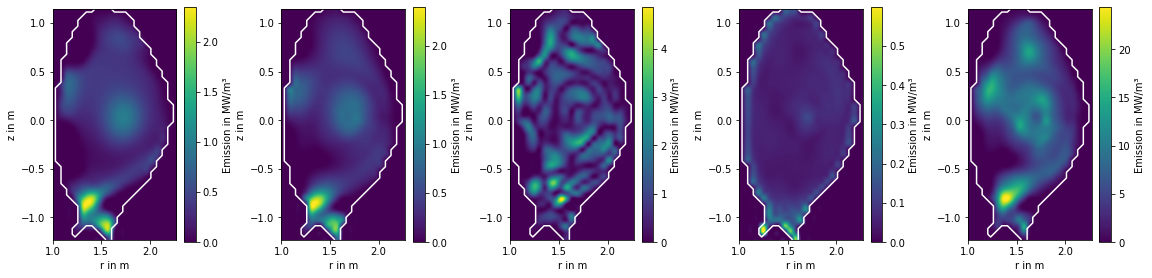

In [18]:
fit_forward_opt, cov_post_forward_opt = performGP(forward_measurement, params_opt,
                            kernel_function="combined_var_z", 
                            magnetic_coords = mag_coords, x_point_up=False)

residuum_opt = residuum(sample_emission, fit_forward_opt, cov_post_forward_opt)
residuum_opt_mean = residuum_mean(sample_emission, fit_forward_opt, cov_post_forward_opt)
signal_to_noise_opt = signal_to_noise(fit_forward_opt, cov_post_forward_opt)
print(residuum_opt_mean)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(16,4))
plot_emission(sample_emission, fig, ax1)
plot_emission(fit_forward_opt, fig, ax2)
plot_emission(residuum_opt, fig, ax3, convert_to_megawatt=False)
plot_emission(np.sqrt(cov_post_forward_opt), fig, ax4)
plot_emission(signal_to_noise_opt, fig, ax5, convert_to_megawatt=False)
plt.tight_layout()

Function call 0: 1423.418
Optimization terminated successfully.
         Current function value: 1417.620578
         Iterations: 91
         Function evaluations: 173
 final_simplex: (array([[7.44987092e+05, 7.32132099e-02, 2.26085217e-01],
       [7.44986160e+05, 7.32133422e-02, 2.26084978e-01],
       [7.44987427e+05, 7.32132332e-02, 2.26085179e-01],
       [7.44986221e+05, 7.32131723e-02, 2.26085022e-01]]), array([1417.62057755, 1417.62057755, 1417.62057755, 1417.62057755]))
           fun: 1417.6205775502326
       message: 'Optimization terminated successfully.'
          nfev: 173
           nit: 91
        status: 0
       success: True
             x: array([7.44987092e+05, 7.32132099e-02, 2.26085217e-01])
0.7867777231022564


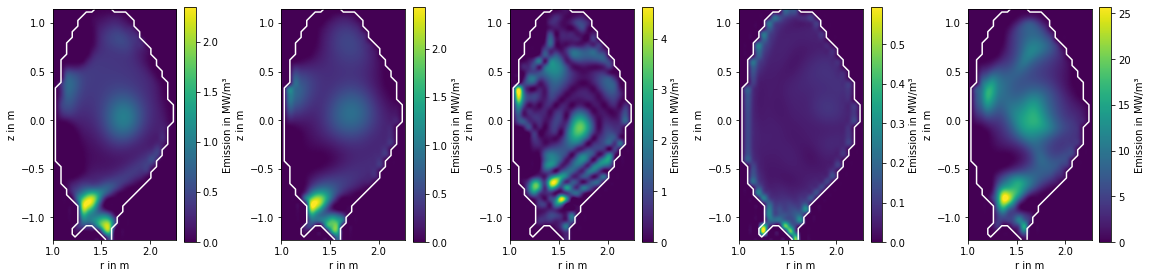

In [8]:
params_opt3 = optimize_params(forward_measurement, [500000, 0.08, 0.15], kernel_function="cartesian_var_z", x_point_up=False)
fit_forward_opt3, cov_post_forward_opt3 = performGP(forward_measurement, params_opt3,
                            kernel_function="cartesian_var_z", x_point_up=False)

residuum_opt = residuum(sample_emission, fit_forward_opt3, cov_post_forward_opt3)
residuum_opt_mean = residuum_mean(sample_emission, fit_forward_opt3, cov_post_forward_opt3)
signal_to_noise_opt = signal_to_noise(fit_forward_opt3, cov_post_forward_opt3)
print(residuum_opt_mean)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(16,4))
plot_emission(sample_emission, fig, ax1)
plot_emission(fit_forward_opt3, fig, ax2)
plot_emission(residuum_opt, fig, ax3, convert_to_megawatt=False)
plot_emission(np.sqrt(cov_post_forward_opt3), fig, ax4)
plot_emission(signal_to_noise_opt, fig, ax5, convert_to_megawatt=False)
plt.tight_layout()

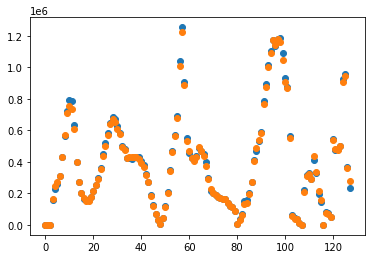

In [12]:
plt.scatter(range(128),forward_measurement)
plt.scatter(range(128),get_forward_measurement(fit_forward_opt3))

In [6]:
params_opt2 = optimize_for_combination(forward_measurement, sample_emission, params_comb, kernel_function="combined_var_z", magnetic_coords=mag_coords)

Function call 0: 2.0584017534063395
Function call 200: 0.6463796551778305
Function call 400: 0.6440624694308283
Function call 600: 0.6391996139943052
 final_simplex: (array([[1.50813082e+06, 8.99373469e-02, 1.62176369e-01, 1.78524511e+07,
        1.67429066e+01, 8.81967171e+02],
       [1.50812605e+06, 8.99375390e-02, 1.62175513e-01, 1.78612389e+07,
        1.67508699e+01, 8.82409301e+02],
       [1.50812600e+06, 8.99376647e-02, 1.62176163e-01, 1.78642331e+07,
        1.67535744e+01, 8.82558782e+02],
       [1.50812775e+06, 8.99379237e-02, 1.62175721e-01, 1.78799989e+07,
        1.67678490e+01, 8.83349795e+02],
       [1.50811895e+06, 8.99376415e-02, 1.62176558e-01, 1.78838460e+07,
        1.67713243e+01, 8.83542514e+02],
       [1.50812032e+06, 8.99373214e-02, 1.62176196e-01, 1.78562282e+07,
        1.67463259e+01, 8.82157389e+02],
       [1.50810649e+06, 8.99368130e-02, 1.62177120e-01, 1.78499400e+07,
        1.67405982e+01, 8.81838572e+02]]), array([0.63919592, 0.63919621, 0.6391962

0.3046360337616355


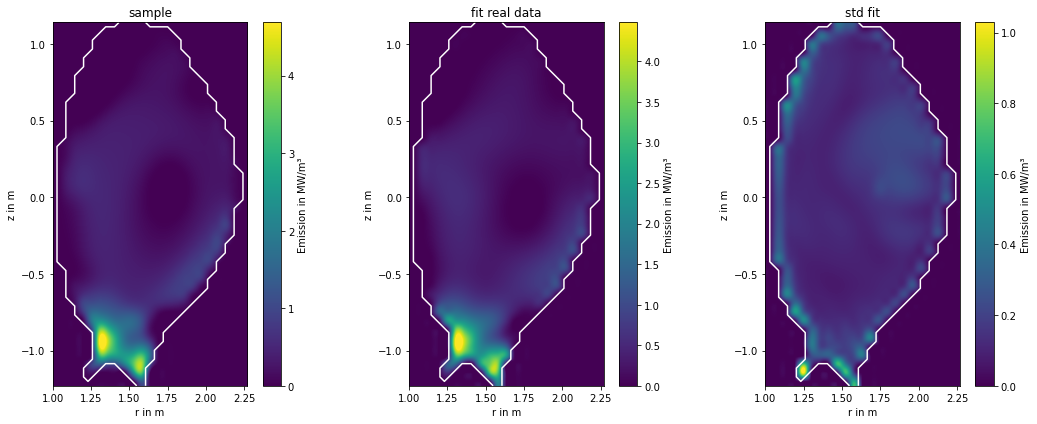

In [8]:
fit_forward_opt2, cov_post_forward_opt2 = performGP(forward_measurement, params_opt2,
                            kernel_function="combined_var_z", 
                            magnetic_coords = mag_coords, x_point_up=False)

residuum_opt2 = residuum(sample_emission, fit_forward_opt2, cov_post_forward_opt2)
residuum_opt_mean2 = residuum_mean(sample_emission, fit_forward_opt2, cov_post_forward_opt2)
print(residuum_opt_mean2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
plot_emission(sample_emission, fig, ax1, title="sample")
plot_emission(fit_forward_opt2, fig, ax2, title="fit real data")
plot_emission(np.sqrt(cov_post_forward_opt2), fig, ax3, "std fit")
plt.tight_layout()

0.2894107612784994


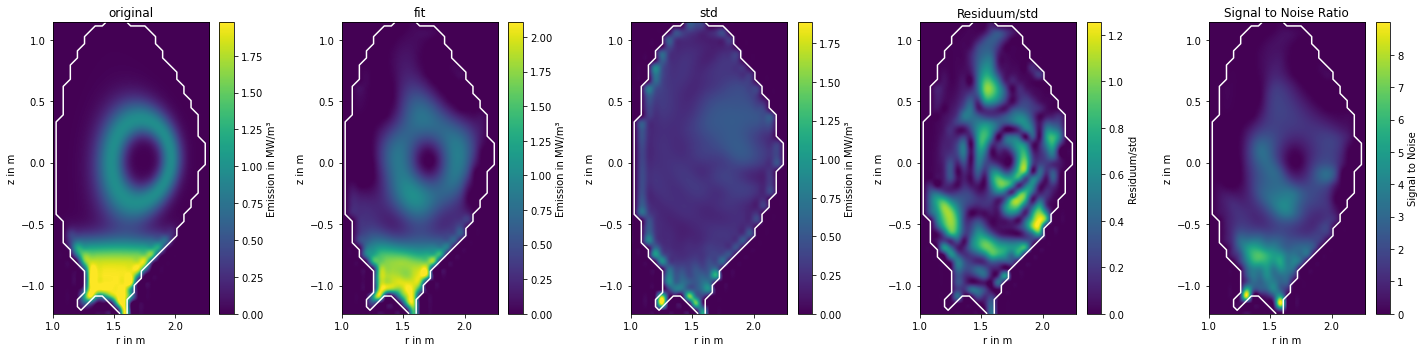

In [15]:
sample = 94

sample_emission = get_sample_emission(sample)
forward_measurement = get_forward_measurement(sample_emission)
mag_coords = load_magnetic_coords(sample)

#params_comb = [157000, 0.164, 0.27, 33230, 0.212, 7.82]
#params_comb = [1.50813082e+06, 8.99373469e-02, 1.62176369e-01, 0*1.78524511e+05, 1.67429066e-01, 8.81967171]
params_comb = [300000, 0.1, 0.20, 150000, 0.15, 6]
params_cart = [2000000, 0.05, 0.15]


fit_forward, cov_post_forward = performGP(forward_measurement, params_cart,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords, x_point_up=False)



std_real = np.sqrt(cov_post_real)
std_forward = np.sqrt(cov_post_forward)

residuum_test = residuum(sample_emission, fit_forward, cov_post_forward)
print(residuum_test[mask].mean())
signal_to_noise_test = signal_to_noise(fit_forward, cov_post_forward)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,5))
plot_emission(sample_emission, fig, ax1, title="original")
plot_emission(fit_forward, fig, ax2, title="fit")
plot_emission(std_forward, fig, ax3, title="std")
plot_emission(residuum_test, fig, ax4, convert_to_megawatt=False, custom_scale_label="Residuum/std", title="Residuum/std")
plot_emission(signal_to_noise_test, fig, ax5, convert_to_megawatt=False, custom_scale_label="Signal to Noise", title="Signal to Noise Ratio")
plt.tight_layout()

In [16]:
from src.plot_helper import compare_emissions
samples = load_sample_attributes()

In [19]:

for sample_number in range(146,222):

    sample = samples.loc[sample_number]
    print(sample_number)
    
    sample_emission = get_sample_emission(sample_number)
    real_measurement = load_saved_bolometer_data(sample_number)
    forward_measurement = get_forward_measurement(sample_emission)
    mag_coords = load_magnetic_coords(sample_number)
    
    x_point_up = sample["x_point_up"]
    time = sample["time"]
    shotnumber = sample["shotnumber"]

    fit_cart, _ = performGP(real_measurement, PARAMS_STATIC_CART,
                                kernel_function="cartesian_var_z", 
                                x_point_up=x_point_up)

    fit_comb, _ = performGP(real_measurement, PARAMS_STATIC_COMB,
                                kernel_function="combined_var_z", 
                                magnetic_coords = mag_coords, x_point_up=x_point_up)

    compare_emissions([sample_emission, fit_cart, fit_comb], ["Fit with real bolometer measurements  for shot {} at t={}s".format(shotnumber, time), 
                                                            "a) sample emission", "b) fit cartesian kernel", "c) fit combined kernel"], figsize=(7.8, 4.5))
    plot_saver("results/fits_static_params/sample{}_static_fit.png".format(sample_number))
    plt.close()
    

146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221


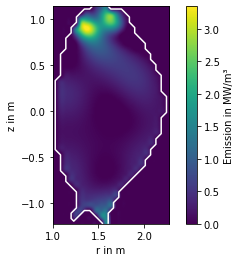

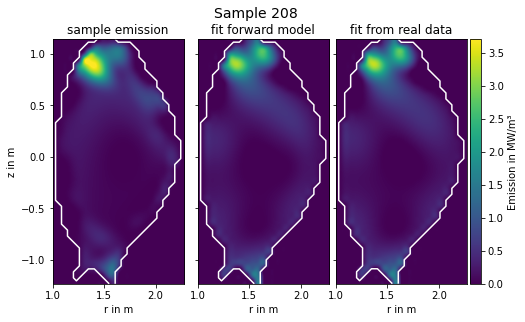

In [14]:
from src.plot_helper import compare_emissions
sample2 = 206

sample_emission3 = get_sample_emission(sample2)
real_measurement = load_saved_bolometer_data(sample2)
forward_measurement3 = get_forward_measurement(sample_emission3)
mag_coords2 = load_magnetic_coords(sample2)

#params_opt_cart3 = optimize_params(forward_measurement3, [500000, 0.1, 0.2], kernel_function="cartesian_var_z", x_point_up=False)

fit_cart3, cov_cart3 = performGP(real_measurement, PARAMS_STATIC_CART,
                            kernel_function="cartesian_var_z", 
                            magnetic_coords = mag_coords2, x_point_up=True)

fit_cart4, cov_cart4 = performGP(real_measurement, PARAMS_STATIC_COMB,
                            kernel_function="combined_var_z", 
                            magnetic_coords = mag_coords2, x_point_up=True)

plot_emission(fit_cart3)

compare_emissions([sample_emission3, fit_cart4,  fit_cart3], 
                    ["Sample 208", "sample emission", "fit forward model", "fit from real data"], figsize=(7.8, 4.5))
#plot_saver("../paper/sections/img/realdata208.png", dpi=350, transparent=True)

In [3]:
np.__config__.show()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib64']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib64']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib64']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib64']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
Supported SIMD extensions in this NumPy install:
    baseline = SSE,SSE2,SSE3
    found = SSSE3,SSE41,POPCNT,SSE42,AVX,F16C,FMA3,AVX2
    not found = AVX512F,AVX512CD,AVX512_KNL,AVX512_KNM,AVX512_SKX,AVX512_CLX,AVX512_CNL,AVX512_ICL


0.030496

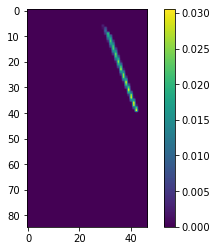

In [7]:
transfer_mat = np.loadtxt("data/full_transfer_volume.txt")
test = np.reshape(transfer_mat[45], [85, 47])
plt.imshow(test)
plt.colorbar()
test.max()

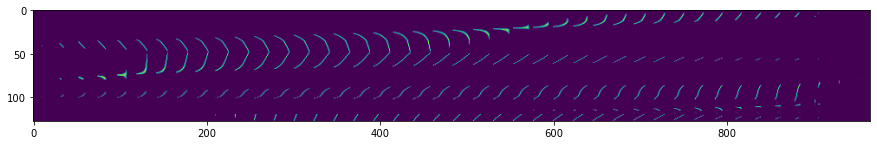

In [36]:
plt.figure(figsize=(15,15))
plt.imshow(transfer_mat)

In [39]:
test = np.arange(1, 5)
print(test)
print(test.reshape([2, 2]))

[1 2 3 4]
[[1 2]
 [3 4]]


In [5]:
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib64']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib64']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib64']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib64']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
Supported SIMD extensions in this NumPy install:
    baseline = SSE,SSE2,SSE3
    found = SSSE3,SSE41,POPCNT,SSE42,AVX,F16C,FMA3,AVX2
    not found = AVX512F,AVX512CD,AVX512_KNL,AVX512_KNM,AVX512_SKX,AVX512_CLX,AVX512_CNL,AVX512_ICL
